# Final presentation

This is the final submission related to the phenomenom of the existence of the existence of Earth's lightning hotspots. As this is the last submission, it will mostly cover the algorithms used during the semester that was currectly giving back information. All plots are present, all code that used is here. Let's load in all the needed packages!

## Goal #1: getting the hotspots of the continents

At this point the simplified ouput is created, meaning a faster workflow with it. Only steps that are need to be done are:

1. Create our first figure with a 2D histogram from the yearly data
2. Create a stable method tha can find peaks in it (may need smoothening)
3. Detect the hotspots on each continent

This was the point of the key paper, let's see how much close we can get to it!

In [1]:
#analysis tools
import numpy as np
import pandas as pd

#simple plots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

#sklearn stuff
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.ndimage import gaussian_filter as gaussian_filter

import sklearn
from sklearn.metrics import pairwise_distances

import sys
import os
import warnings
import pathlib
import glob

#handling specific files
import h5py
import netCDF4
from netCDF4 import Dataset, num2date
from datetime import datetime

import shapefile
import copy

import conda

#attach projector
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

#import projector
from mpl_toolkits.basemap import Basemap

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#for polygon masks
from skimage import draw as drw

import holoviews as hv
import bokeh as bk

from bokeh.models import BasicTicker, ColorBar, LinearColorMapper, PrintfTickFormatter
from bokeh.plotting import figure, show

In [17]:
def hide_code_in_slideshow():   
    from IPython import display
    import binascii
    import os
    uid = binascii.hexlify(os.urandom(8)).decode()    
    html = """<div id="%s"></div>
    <script type="text/javascript">
        $(function(){
            var p = $("#%s");
            if (p.length==0) return;
            while (!p.hasClass("cell")) {
                p=p.parent();
                if (p.prop("tagName") =="body") return;
            }
            var cell = p;
            cell.find(".input").addClass("hide-in-slideshow")
        });
    </script>""" % (uid, uid)
    display.display_html(html, raw=True)

# Simplified output

Its source is the .h5 avaliable on kooplex. This is not needed to be recreated as I will hand this out. The problem is that the .h5 are a bit messy to handle, has insane amount of data and a dozen of parameters recorded in themselves. Thats why the simplified output was created during the semester: we only need a fraction of the data. Later on we will discover another issue, hidden from plain sight...

In [3]:
#let's load in the simplified data!

col_names = ["time","long","lat"]
simplified_data = pd.read_csv("../data/simplified/simplified.csv", skiprows=4, delimiter=" ", names=col_names)
print(simplified_data.info(), simplified_data.values.shape)


xedges_0 = np.arange(-180,181)
yedges_0 = np.arange(-54,55)

#these are arbetrarily choosen 
xedges_1 = np.linspace(-180,180,int(12742/6/2)+1)
yedges_1 = np.linspace(-54,54,int(12742/6/2 * (54/180))+1)

#generate the hist2d
HIST2D, x_edges, y_edges = np.histogram2d(simplified_data["long"].values,simplified_data["lat"].values,
                                         bins=(xedges_1,yedges_1))
print(HIST2D.shape) 
HIST2D = HIST2D.T   #you can transform it, as it is mostly used in this way for imshow, pcolormesh

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798991 entries, 0 to 798990
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    798991 non-null  float64
 1   long    798991 non-null  float64
 2   lat     798991 non-null  float64
dtypes: float64(3)
memory usage: 18.3 MB
None (798991, 3)
(1061, 318)


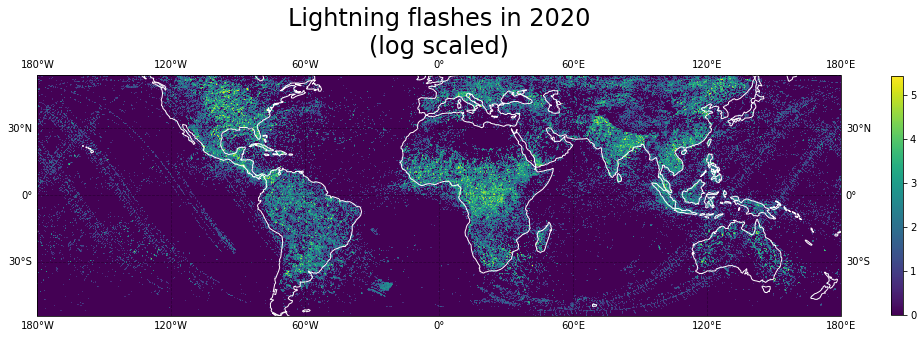

In [37]:
hide_code_in_slideshow()

fig = plt.figure(figsize=(18,10))

map = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))
gl = map.gridlines(crs=ccrs.PlateCarree(central_longitude=0.0),
                   draw_labels=True,
                   linewidth=0.8,
                   alpha=0.3,
                   color="black",
                   linestyle="--")

gl.ylocator = mticker.FixedLocator([-90,-60,-30,0,30,60,90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
#gl.xlabels_top=False
#gl.ylabels_right=False

plt.title('Lightning flashes in 2020\n(log scaled)', fontsize=24)
X, Y = np.meshgrid(x_edges, y_edges)
plt1 = plt.pcolormesh(X, Y, np.log(HIST2D+1) )
fig.colorbar(plt1, shrink = 0.44)

map.coastlines(color="white")

plt.xlabel("Longitude [°]",fontsize=28)
plt.ylabel("Latitude [°]",fontsize=28)

plt.xlim(-180,180)
plt.ylim(-54,54)

#fig.tight_layout()
plt.savefig("../figs/lightning_flashes_2020.png", format="png", dpi=150)
plt.show()

![alt text](../figs/lightning_flashes_2020.png "Title")

## Top 10 most thunderous spots for each continent

There will be a lot of masks, with the shapefiles for the well somewhat well defined surfaces. What is being used here is the following:

1. The shapefile to define the surfaces
2. A gaussian filter to determine hotspots

In [5]:
def coord_to_pix(c,min_v,max_v,pix_count):
    """
    Converts from coordinate to pixel
    """
    return np.around((c-min_v) * pix_count / (max_v - min_v))
def pix_to_coord(pix,min_v,max_v,pix_count):
    """
    Converts from pixel to coordinate
    """
    return pix * (max_v - min_v) / pix_count + min_v

def get_shapes(cont_name):
    """
    Description:
        This function loads a burnt in shapefile,
        which in the end returns the list of lands
        part of the continent in a more usable format.
    
    INPUT:
        Continent name (STRING)
    OUTPUT:
        List of coordinates of lands that are part of the continent
    
    """
    
    borders_name = "../data/borders/continents/continent.shp"
    sf = shapefile.Reader(borders_name, encoding='ISO8859-1')  #special, to handle an extensive amo8unt of encoding
    shape_records = sf.shapeRecords()
    
    desired_shapes = []
    
    for s in shape_records:
        if s.record[0] == cont_name:
            desired_shapes.append(s.shape)

    cont = (desired_shapes[0].__geo_interface__)['coordinates']
    print("Land areas found as part of the continent {0} : {1}".format(cont_name, len(cont)))
    cont_list = []

    for i in range(len(cont)):
        cont_list.append(np.array([list(elem) for elem in cont[i][0]]))
        
    return cont_list

def continent_masker(HIST2D,cont_borders,xedges,yedges):
    """
    Utilizes skimage draw. Creates masks from polygon coordinate data.
    Skimage draw returns coords for the original 2d array, so it
    expects indeces as coordinates for points.
    INPUT:
        HIST2D: 2d array with data
        cont_border: coordinates for polygon shapes for the HIST2D to be drawn on
        xedges: array containing the bin edges
        yedges: array containing the bin edges
    OUTPUT:
        mask_cont: comes with the same shape as HIST2D, an array consisting of 0 and 1
                    not a real masks that is True of False
    """

    mask_cont= np.zeros(HIST2D.shape); mask_cont = mask_cont.T
    for i in cont_borders:
        rr , cc = drw.polygon(i[:,0], i[:,1])
        rr = np.where(rr > (len(xedges)-2),(len(xedges)-2),rr )    
        cc = np.where(cc > (len(yedges)-2),(len(yedges)-2),cc )    #it mostly likely go over the boundary in latitude
        mask_cont[rr,cc] = 1                                         #for example, Greenland, which is part of N. America
    return mask_cont

def max_search(array_2d,num):
    """
    INPUT:
        array_2d: 2 indexed array
        num: number of maxes
    OUTPUT:
        indices of maxes
    """
    N = num    #top N
    idx = np.argsort((array_2d).ravel())[-N:][::-1] #single slicing: `[:N-2:-1]`
    topN_val = array_2d.ravel()[idx]
    row_col = np.c_[np.unravel_index(idx, array_2d.shape)]
    return topN_val, row_col

def detect_peaks(image):
    """
    Takes an image and detect the peaks usingthe local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """

    # define an 8-connected neighborhood
    neighborhood = generate_binary_structure(2,2)

    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.

    #we create the mask of the background
    background = (image==0)

    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    detected_peaks = local_max ^ eroded_background

    return detected_peaks

In [6]:
#https://stackoverflow.com/questions/33634902/how-to-get-the-borders-of-each-country
#https://www.arcgis.com/home/item.html?id=3c4741e22e2e4af2bd4050511b9fc6ad
borders_name = "../data/borders/continents/continent.shp"
sf = shapefile.Reader(borders_name, encoding='ISO8859-1')
shape_records = sf.shapeRecords()

#North America
na_parts = get_shapes('North America')
na_parts_p = copy.deepcopy(na_parts)
na_parts_c = copy.deepcopy(na_parts)
#South America
sa_parts = get_shapes('South America')
sa_parts_p = copy.deepcopy(sa_parts)
sa_parts_c = copy.deepcopy(sa_parts)
#Asia
as_parts = get_shapes('Asia')
as_parts_p = copy.deepcopy(as_parts)
as_parts_c = copy.deepcopy(sa_parts)
#Australia
au_parts = get_shapes('Australia')
au_parts_p = copy.deepcopy(au_parts)
au_parts_c = copy.deepcopy(au_parts)
#Europe
eu_parts = get_shapes('Europe')
eu_parts_p = copy.deepcopy(eu_parts)
eu_parts_c = copy.deepcopy(eu_parts)
#Africa
af_parts = get_shapes('Africa')
af_parts_p = copy.deepcopy(af_parts)
af_parts_c = copy.deepcopy(af_parts)

#Oceania is now Australia
oc_parts = get_shapes('Oceania')
oc_parts_p = copy.deepcopy(oc_parts)
oc_parts_c = copy.deepcopy(oc_parts)

dx = (xedges_1[1] - xedges_1[0])
dy = (yedges_1[1] - yedges_1[0])
print(dx, "\n", dy)                 #not exactly, but almost the same step size
print(len(xedges_1), len(yedges_1))
print(coord_to_pix(180,-180,180,len(xedges_1)-1))

#onto conversion
for i in range(len(na_parts_p)):
    na_parts_p[i][:,0] = coord_to_pix(na_parts_p[i][:,0],-180,180,len(xedges_1)-1)
    na_parts_p[i][:,1] = coord_to_pix(na_parts_p[i][:,1],-54,54,len(yedges_1)-1)
    
for i in eu_parts_p:
    i[:,0] = coord_to_pix(i[:,0],-180,180,len(xedges_1)-1)
    i[:,1] = coord_to_pix(i[:,1],-54,54,len(yedges_1)-1)

for i in sa_parts_p:
    i[:,0] = coord_to_pix(i[:,0],-180,180,len(xedges_1)-1)
    i[:,1] = coord_to_pix(i[:,1],-54,54,len(yedges_1)-1)
    
for i in af_parts_p:
    i[:,0] = coord_to_pix(i[:,0],-180,180,len(xedges_1)-1)
    i[:,1] = coord_to_pix(i[:,1],-54,54,len(yedges_1)-1)
    
for i in as_parts_p:
    i[:,0] = coord_to_pix(i[:,0],-180,180,len(xedges_1)-1)
    i[:,1] = coord_to_pix(i[:,1],-54,54,len(yedges_1)-1)
    
for i in au_parts_p:
    i[:,0] = coord_to_pix(i[:,0],-180,180,len(xedges_1)-1)
    i[:,1] = coord_to_pix(i[:,1],-54,54,len(yedges_1)-1)
    
for i in oc_parts_p:
    i[:,0] = coord_to_pix(i[:,0],-180,180,len(xedges_1)-1)
    i[:,1] = coord_to_pix(i[:,1],-54,54,len(yedges_1)-1)

Land areas found as part of the continent North America : 631
Land areas found as part of the continent South America : 188
Land areas found as part of the continent Asia : 487
Land areas found as part of the continent Australia : 35
Land areas found as part of the continent Europe : 296
Land areas found as part of the continent Africa : 55
Land areas found as part of the continent Oceania : 135
0.33930254476908317 
 0.3396226415094361
1062 319
1061.0


In [7]:
mask_na = continent_masker(HIST2D,na_parts_p,xedges_1,yedges_1)
mask_sa = continent_masker(HIST2D,sa_parts_p,xedges_1,yedges_1)
mask_eu = continent_masker(HIST2D,eu_parts_p,xedges_1,yedges_1)
mask_af = continent_masker(HIST2D,af_parts_p,xedges_1,yedges_1)
mask_au = continent_masker(HIST2D,au_parts_p,xedges_1,yedges_1)
mask_as = continent_masker(HIST2D,as_parts_p,xedges_1,yedges_1)
mask_oc = continent_masker(HIST2D,oc_parts_p,xedges_1,yedges_1)

mask_au = mask_au + mask_oc



HIST2D_gauss_smooth0 = gaussian_filter(HIST2D, sigma=0.5, mode='constant')

#https://stackoverflow.com/questions/46554647/returning-the-n-largest-values-indices-in-a-multidimensional-array-can-find-so
topN_val_af, row_col_af = max_search(HIST2D_gauss_smooth0.T*mask_af,10)
topN_val_as, row_col_as = max_search(HIST2D_gauss_smooth0.T*mask_as,10)
topN_val_eu, row_col_eu = max_search(HIST2D_gauss_smooth0.T*mask_eu,10)
topN_val_na, row_col_na = max_search(HIST2D_gauss_smooth0.T*mask_na,10)
topN_val_sa, row_col_sa = max_search(HIST2D_gauss_smooth0.T*mask_sa,10)
topN_val_au, row_col_au = max_search(HIST2D_gauss_smooth0.T*mask_au,10)
topN_coords_af = []
topN_coords_as = []
topN_coords_eu = []
topN_coords_na = []
topN_coords_sa = []
topN_coords_au = []
for i in range(10):
    topN_coords_af.append([pix_to_coord(row_col_af[i][0],-180,180,len(xedges_1)-2),
                           pix_to_coord(row_col_af[i][1],-54,54,len(yedges_1)-2)])
    topN_coords_as.append([pix_to_coord(row_col_as[i][0],-180,180,len(xedges_1)-2),
                           pix_to_coord(row_col_as[i][1],-54,54,len(yedges_1)-2)])
    topN_coords_eu.append([pix_to_coord(row_col_eu[i][0],-180,180,len(xedges_1)-2),
                           pix_to_coord(row_col_eu[i][1],-54,54,len(yedges_1)-2)])
    topN_coords_na.append([pix_to_coord(row_col_na[i][0],-180,180,len(xedges_1)-2),
                           pix_to_coord(row_col_na[i][1],-54,54,len(yedges_1)-2)])
    topN_coords_sa.append([pix_to_coord(row_col_sa[i][0],-180,180,len(xedges_1)-2),
                           pix_to_coord(row_col_sa[i][1],-54,54,len(yedges_1)-2)])
    topN_coords_au.append([pix_to_coord(row_col_au[i][0],-180,180,len(xedges_1)-2),
                           pix_to_coord(row_col_au[i][1],-54,54,len(yedges_1)-2)])
topN_coords_af = np.array(topN_coords_af)
topN_coords_as = np.array(topN_coords_as)
topN_coords_eu = np.array(topN_coords_eu)
topN_coords_na = np.array(topN_coords_na)
topN_coords_sa = np.array(topN_coords_sa)
topN_coords_au = np.array(topN_coords_au)

In [8]:
topN_coords_af

array([[  9.8490566 ,  11.75394322],
       [  8.83018868,  12.43533123],
       [ 28.18867925,  -1.53312303],
       [ 22.75471698,  -1.19242902],
       [ 28.18867925,  -0.170347  ],
       [ 24.79245283,   0.51104101],
       [ 27.8490566 ,  -1.19242902],
       [ 27.16981132,  -2.89589905],
       [ 24.45283019, -30.15141956],
       [  9.16981132,  12.43533123]])

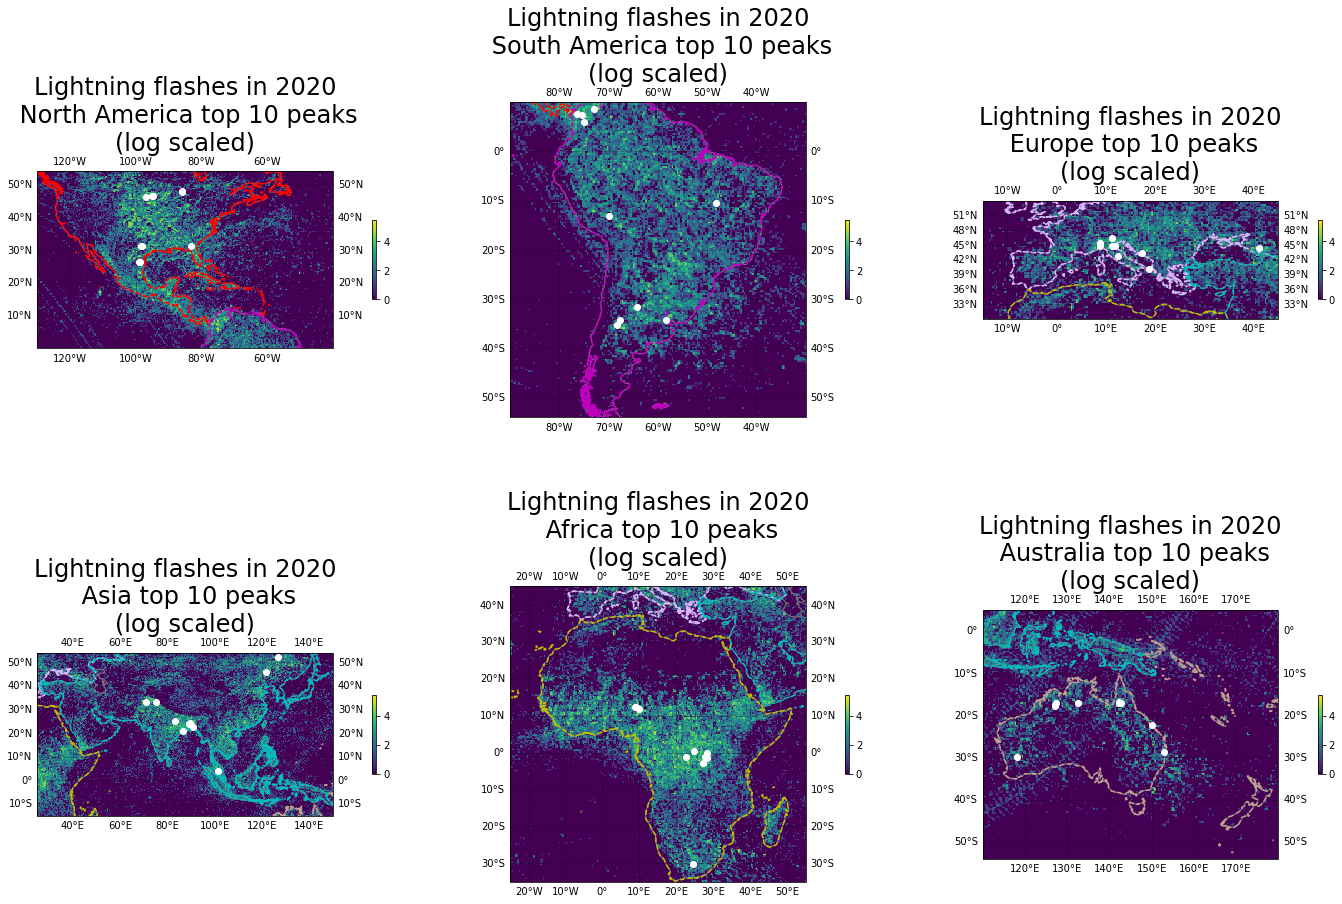

In [58]:
X, Y = np.meshgrid(x_edges, y_edges)

#get the 6 plots for the 6 continents
fig, axes = plt.subplots(2,3, figsize=(24,16), subplot_kw={"projection" : ccrs.PlateCarree(central_longitude=0.0) })
for i in axes:
    for j in i:
        j.gridlines(crs=ccrs.PlateCarree(central_longitude=0.0),
                   draw_labels=True,
                   linewidth=0.8,
                   alpha=0.3,
                   color="black",
                   linestyle="--")
        j.coastlines(color="gray")
        im1 = j.pcolormesh(X, Y, np.log((HIST2D.T+1).T) )
        fig.colorbar(im1,ax=j,pad=0.1, shrink=0.2)
        for ij in na_parts:
            j.plot(ij[:,0],ij[:,1], "--r")
        for ij in sa_parts:
            j.plot(ij[:,0],ij[:,1], "--m")
        for ij in eu_parts:
            j.plot(ij[:,0],ij[:,1], "--", color="#dbb5ff")
        for ij in af_parts:
            j.plot(ij[:,0],ij[:,1], "--y")
        for ij in au_parts:
            j.plot(ij[:,0],ij[:,1], "--", color="#bf9f8e")
        for ij in as_parts:
            j.plot(ij[:,0],ij[:,1], "--c")
        for ij in oc_parts:
            j.plot(ij[:,0],ij[:,1], "--", color="#bf9f8e")
            
#crude method, as it could be done in for cicles             
axes[0,0].set_title('Lightning flashes in 2020\n North America top 10 peaks\n(log scaled)', fontsize=24)
axes[0,1].set_title('Lightning flashes in 2020\n South America top 10 peaks\n(log scaled)', fontsize=24)
axes[0,2].set_title('Lightning flashes in 2020\n Europe top 10 peaks\n(log scaled)', fontsize=24)
axes[1,0].set_title('Lightning flashes in 2020\n Asia top 10 peaks\n(log scaled)', fontsize=24)
axes[1,1].set_title('Lightning flashes in 2020\n Africa top 10 peaks\n(log scaled)', fontsize=24)
axes[1,2].set_title('Lightning flashes in 2020\n Australia top 10 peaks\n(log scaled)', fontsize=24)
#ONTO INDIVIDUAL PLOTS
#NORTH AMERICA
axes[0,0].set_xlim(-130,-40)
axes[0,0].set_ylim(0,54)

axes[0,0].plot(topN_coords_na[:,0], topN_coords_na[:,1], " wo")

#SOUTH AMERICA
axes[0,1].set_xlim(-90,-30)
axes[0,1].set_ylim(-54,10)

axes[0,1].plot(topN_coords_sa[:,0], topN_coords_sa[:,1], " wo")

#EUROPE
axes[0,2].set_xlim(-15,45)
axes[0,2].set_ylim(30,54)

axes[0,2].plot(topN_coords_eu[:,0], topN_coords_eu[:,1], " wo")

#ASIA
axes[1,0].set_xlim(25,150)
axes[1,0].set_ylim(-15,54)

axes[1,0].plot(topN_coords_as[:,0], topN_coords_as[:,1], " wo")

#AFRICA
axes[1,1].set_xlim(-25,55)
axes[1,1].set_ylim(-35,45)

axes[1,1].plot(topN_coords_af[:,0], topN_coords_af[:,1], " wo")

#AUSTRALIA
axes[1,2].set_xlim(110,180)
axes[1,2].set_ylim(-54,5)

axes[1,2].plot(topN_coords_au[:,0], topN_coords_au[:,1], " wo")


#fig.tight_layout()
plt.savefig("../figs/lightning_flashes_2020_per_cont4.png", format="png", dpi=60)
plt.show()

![ajsas](../figs/lightning_flashes_2020_per_cont4.png "put some txt here brah")

## Conclusions

We can compare this to the keypaper's results and it seems like it somewhat consistent. The keypaper states that the yearly analysis could be done in order to track the climate change. Also, if someone is good in topography, you could see that the hotspots locations are mostly under on climate on each continent. The most hotspots are located at:

1. in the Kongo Basin in Africa
2. The west foothills of Alps in Europe
3. The west coastline of Australia
4. THe west foothills of Himalaja in Asia

## Goal #2: comparing other data with LIS ISS' data

In order to get the a deeper understanding and give an explanation, we have to compare these results to other datasets to draw conclusion about what may be behind the phenomenom. Personally I like the idea of wind pushing humid are to dry land that is meeting and obstructive surface (mountains). This means that the windspeed is generally slower in these areas. The problem is that most wind data is either a forecast, or should not be used for scientific models (or behind paywall). In this case I have choosen a dataset that is for observation only but should be good in this case!

### Problems with wind

The problem using wind measurements is that we instictively know that even during the day, the windspeed and direction changes, but the lightning hotspots are observed through a longer times interval. In order to choose the best day (at least) to describe, we need do to a seasonal or daily analysis. Let's get onto this!

In [10]:
continents_top_locs = np.zeros((6,topN_coords_eu.shape[0], topN_coords_eu.shape[1]))
#print(continents_top_locs.shape)

#NA, SA, EU, AF, AS, AU
continents_top_locs[0,:,:] = row_col_na[:,:]
continents_top_locs[1] = row_col_sa
continents_top_locs[2] = row_col_eu
continents_top_locs[3] = row_col_af
continents_top_locs[4] = row_col_as
continents_top_locs[5] = row_col_au

col_names = ["time","long","lat"]
simplified_data = pd.read_csv("../data/simplified/simplified.csv",
                              skiprows=4,
                              delimiter=" ",
                              names=col_names,
                             # parse_dates=[2],
                             # date_parser=pd.to_datetime
                             )
#print(simplified_data.info(), simplified_data.values.shape)

epoch = pd.to_datetime("1993-01-01 00:00:00.000")
epoch_s = epoch.to_julian_date()*3600*24
#print(epoch_s)
times = simplified_data['time'].to_list()
times0 = pd.DatetimeIndex(simplified_data['time']).floor('s').to_julian_date()
#print(times0)

#testing 
TAI93_epoch = pd.to_datetime("1993-01-01 00:00:00")
#print(TAI93_epoch)
pandas_epoch = pd.to_datetime(0, unit='s')
#print(pandas_epoch)

#print(TAI93_epoch.to_julian_date())
#print(pandas_epoch.to_julian_date())

#print(pd.to_datetime((2448988.5 + simplified_data["time"].values[0] / 24 / 3600) - pandas_epoch.to_julian_date(), unit='D', utc=True))
#print(pd.to_datetime((2448988.5 + simplified_data["time"].values[-1] / 24 / 3600) - pandas_epoch.to_julian_date(), unit='D', utc=True))

start_2020 = pd.to_datetime("2020-01-01 00:00:00")
start_2021 = pd.to_datetime("2021-01-01 00:00:00")
date_bins = np.linspace((start_2020.to_julian_date() - TAI93_epoch.to_julian_date()) * 24 * 3600,
                        (start_2021.to_julian_date() - TAI93_epoch.to_julian_date()) * 24 * 3600,
                        int(start_2021.to_julian_date() - start_2020.to_julian_date()+1))
date_s_ = date_bins[:-1]
date_e_ = date_bins[1:]

xedges_1 = np.linspace(-180,180,int(12742/6/2)+1)
yedges_1 = np.linspace(-54,54,int(12742/6/2 * (54/180))+1)

hists_for_tops = np.zeros((6,10,len(date_bins)-1))


#loop through each bin, make a hist2d
#cut of indexed locations
for j in range(len(date_s_)):
    
    start = date_s_[j]
    end = date_e_[j]

    mask = (simplified_data['time'].values > start) * (simplified_data['time'].values < end) #it needs parentheses for partial results, otherwise numpy cannot decide truth value
    
    #make hist2d with mask
    p_HIST2D, p_x_edges, p_y_edges = np.histogram2d(simplified_data["long"].values[mask],simplified_data["lat"].values[mask],
                                         bins=(xedges_1,yedges_1))
    p_HIST2D = p_HIST2D.T
    
    #for each continent
    for i,cont in enumerate(continents_top_locs):
        #print(i,cont)
        #for each hotspot on each continent
        for k in range(len(cont)):
            #print(p_HIST2D.shape , cont[k,0], cont[k,1])
            sub_data = p_HIST2D[int(cont[k,1]),int(cont[k,0])]
            hists_for_tops[i,k,j] = sub_data

masks = []
masks.append(mask_na)
masks.append(mask_sa)
masks.append(mask_eu)
masks.append(mask_af)
masks.append(mask_as)
masks.append(mask_au)
#print(np.unique(mask_na, return_counts=True))
#print(np.unique(mask_sa, return_counts=True))
#print(np.unique(mask_eu, return_counts=True))
#print(np.unique(mask_af, return_counts=True))
#print(np.unique(mask_as, return_counts=True))
#print(np.unique(mask_au, return_counts=True))


xedges_1 = np.linspace(-180,180,int(12742/6/2)+1)
yedges_1 = np.linspace(-54,54,int(12742/6/2 * (54/180))+1)

hist_for_each_cont = np.zeros((6,len(date_s_)))


#loop through each bin, make a hist2d
#cut of indexed locations
for j in range(len(date_s_)):
    
    start = date_s_[j]
    end = date_e_[j]

    mask = (simplified_data['time'].values > start) * (simplified_data['time'].values < end) #it needs parentheses for partial results, otherwise numpy cannot decide truth value
    
    #make hist2d with mask
    p_HIST2D, p_x_edges, p_y_edges = np.histogram2d(simplified_data["long"].values[mask],simplified_data["lat"].values[mask],
                                         bins=(xedges_1,yedges_1))
    p_HIST2D = p_HIST2D.T
    
    #for each continent
    for i,cont in enumerate(masks):
        #print(i,cont)
        sub_sum = np.sum(p_HIST2D * cont.T)
        hist_for_each_cont[i,j] = sub_sum

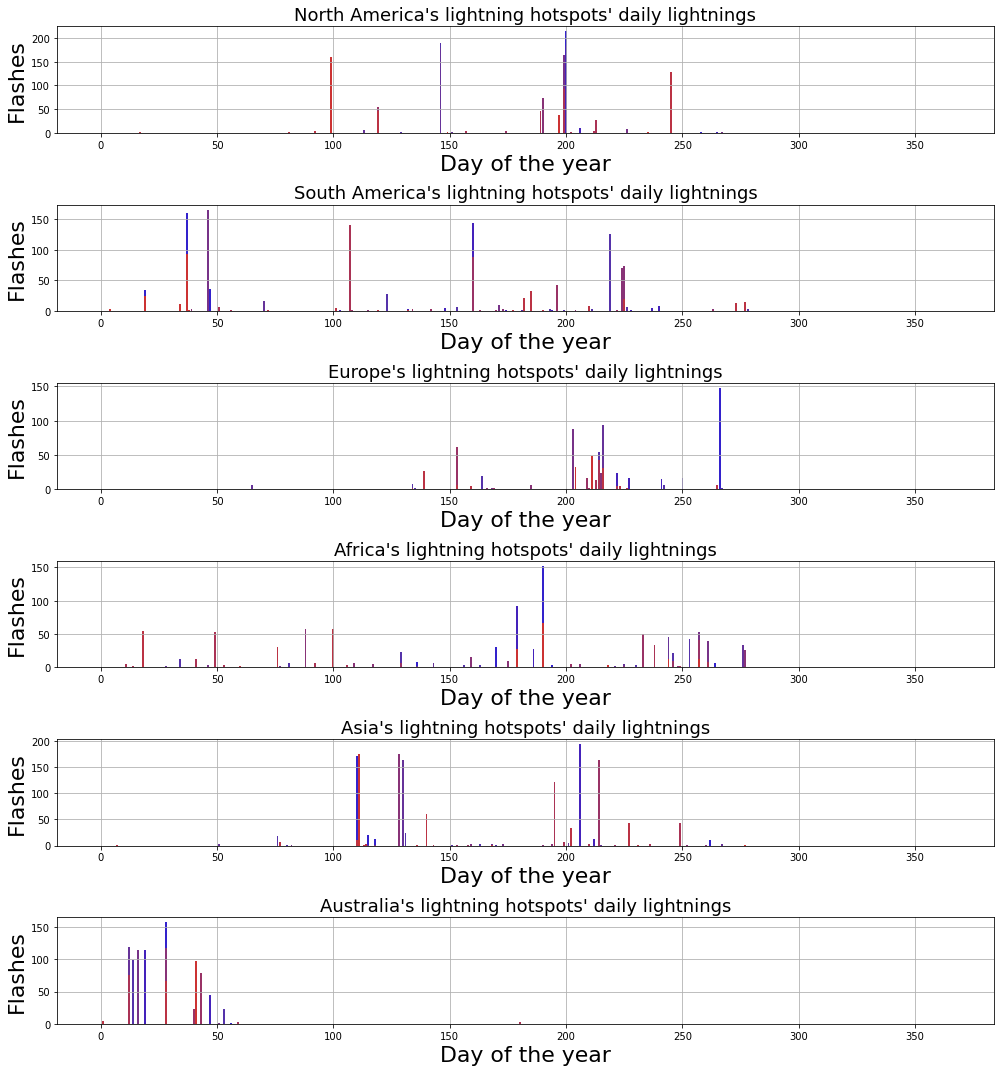

In [47]:
titles = ["North America's lightning hotspots' daily lightnings",
        "South America's lightning hotspots' daily lightnings",
        "Europe's lightning hotspots' daily lightnings",
        "Africa's lightning hotspots' daily lightnings",
        "Asia's lightning hotspots' daily lightnings",
        "Australia's lightning hotspots' daily lightnings"]

colors = ["#3322CC",
         "#4422BB",
         "#5533AA",
         "#663399",
         "#773388",
         "#883377",
         "#993366",
         "#AA3355",
         "#BB3344",
         "#CC3333"]

fig,axes = plt.subplots(6,1,figsize=(14,15))

for idx, j in enumerate(axes):
    j.set_title(titles[idx], fontsize=18)
    for i in range(10):
        j.bar(np.arange(366),hists_for_tops[idx,i,:],color=colors[i], label=("{0}th spot".format((i+1))))
    j.set_xlabel("Day of the year", fontsize=22)
    j.set_ylabel("Flashes",fontsize=22)

    j.grid()
    #j.legend(loc="best", fontsize=9)
    
fig.tight_layout()
plt.savefig("../figs/top10_loc_daily_lightning.png", format="png", dpi=150)
plt.show()

![ajsas](../figs/top10_loc_daily_lightning.png "put some txt here brah")

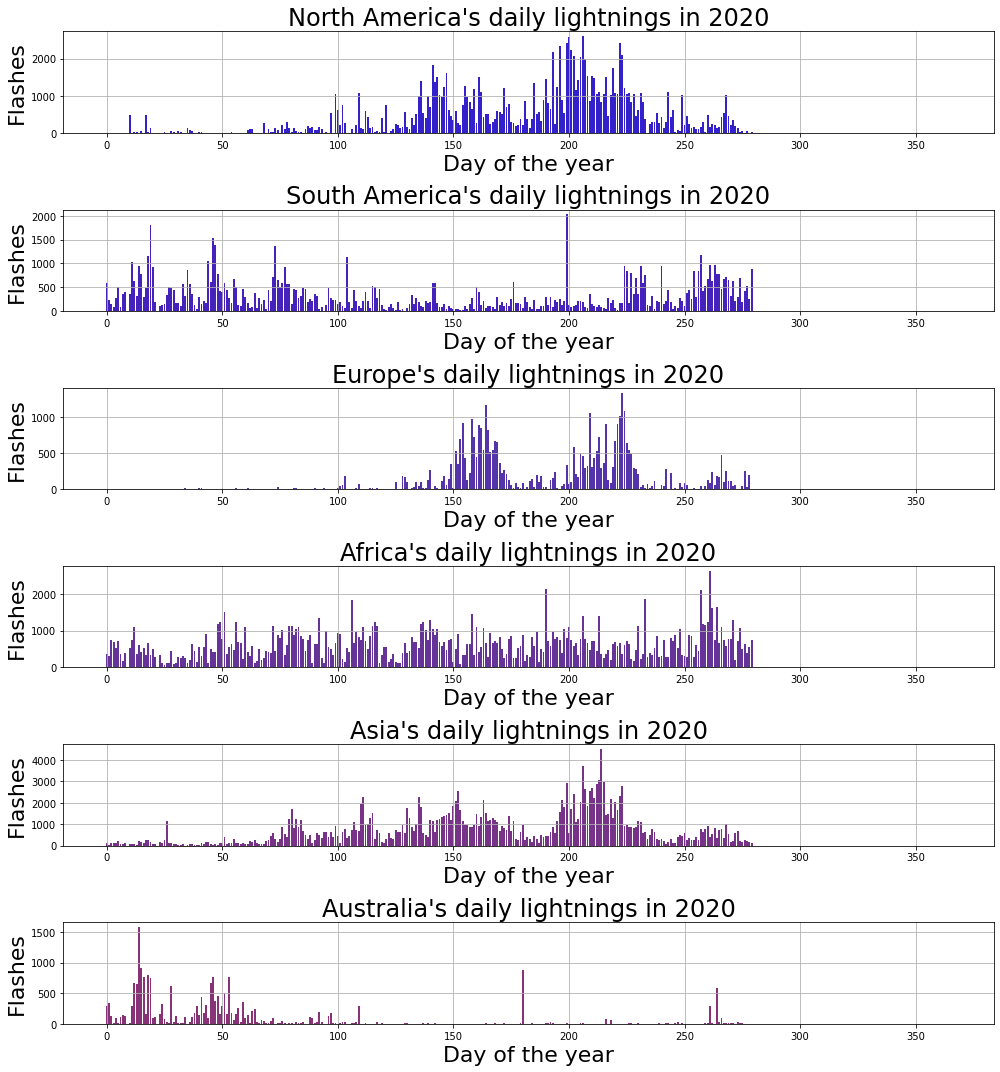

In [48]:
titles = ["North America's daily lightnings in 2020",
        "South America's daily lightnings in 2020",
        "Europe's daily lightnings in 2020",
        "Africa's daily lightnings in 2020",
        "Asia's daily lightnings in 2020",
        "Australia's daily lightnings in 2020"]

fig,axes = plt.subplots(6,1,figsize=(14,15))
for idy,j in enumerate(axes):

    j.set_title(titles[idy], fontsize=24)
    j.bar(np.arange(366),hist_for_each_cont[idy,:],color=colors[idy])
    j.set_xlabel("Day of the year", fontsize=22)
    j.set_ylabel("Flashes",fontsize=22)

    j.grid()
    
fig.tight_layout()
plt.savefig("../figs/continents_daily_lightning.png", format="png", dpi=150)
plt.show()

![ajsas](../figs/continents_daily_lightning.png "put some txt here brah")

${\bf \text{Whoops, something is not okay!}}$

The problem is that the data that is avaliable on kooplex is till 10/06. And NASA's datawarehouse for the LIS ISS data goes from version 1.0 to 2.0, the older data (so the missing part of 2020) is hardly accessable.

${\bf \text{But this data covers significant part of the year!}}$

## Getting the wind data

Used wind data source are here:

https://data.remss.com/ccmp/v02.1.NRT/

https://images.remss.com/figures/measurements/ccmp/Mears_2019_CCMP_NRT_JGR.pdf

The problem with this is this uses the netCDF4 file format.

In [13]:
#preps
path_w = "E:/_ELTE_PHYS_MSC/3_third_semester/datascience/data/wind_data/my_days/"
file1 = "CCMP_RT_Wind_Analysis_20200120_V02.1_L3.0_RSS.nc"
file2 = "CCMP_RT_Wind_Analysis_20200316_V02.1_L3.0_RSS.nc"
file3 = "CCMP_RT_Wind_Analysis_20200613_V02.1_L3.0_RSS.nc"
file4 = "CCMP_RT_Wind_Analysis_20200718_V02.1_L3.0_RSS.nc"
file5 = "CCMP_RT_Wind_Analysis_20200728_V02.1_L3.0_RSS.nc"
file6 = "CCMP_RT_Wind_Analysis_20200916_V02.1_L3.0_RSS.nc"

#load in one
au_wind = netCDF4.Dataset(path_w + file1, "r", format="NETCDF4") 
sa_wind = netCDF4.Dataset(path_w + file2, "r", format="NETCDF4") 
eu_wind = netCDF4.Dataset(path_w + file3, "r", format="NETCDF4") 
na_wind = netCDF4.Dataset(path_w + file4, "r", format="NETCDF4") 
as_wind = netCDF4.Dataset(path_w + file5, "r", format="NETCDF4") 
af_wind = netCDF4.Dataset(path_w + file6, "r", format="NETCDF4") 

net_cdfs = []
net_cdfs.append(au_wind)
net_cdfs.append(sa_wind)
net_cdfs.append(eu_wind)
net_cdfs.append(na_wind)
net_cdfs.append(as_wind)
net_cdfs.append(af_wind)

<ipython-input-59-5e53fb6e6a05>:45: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


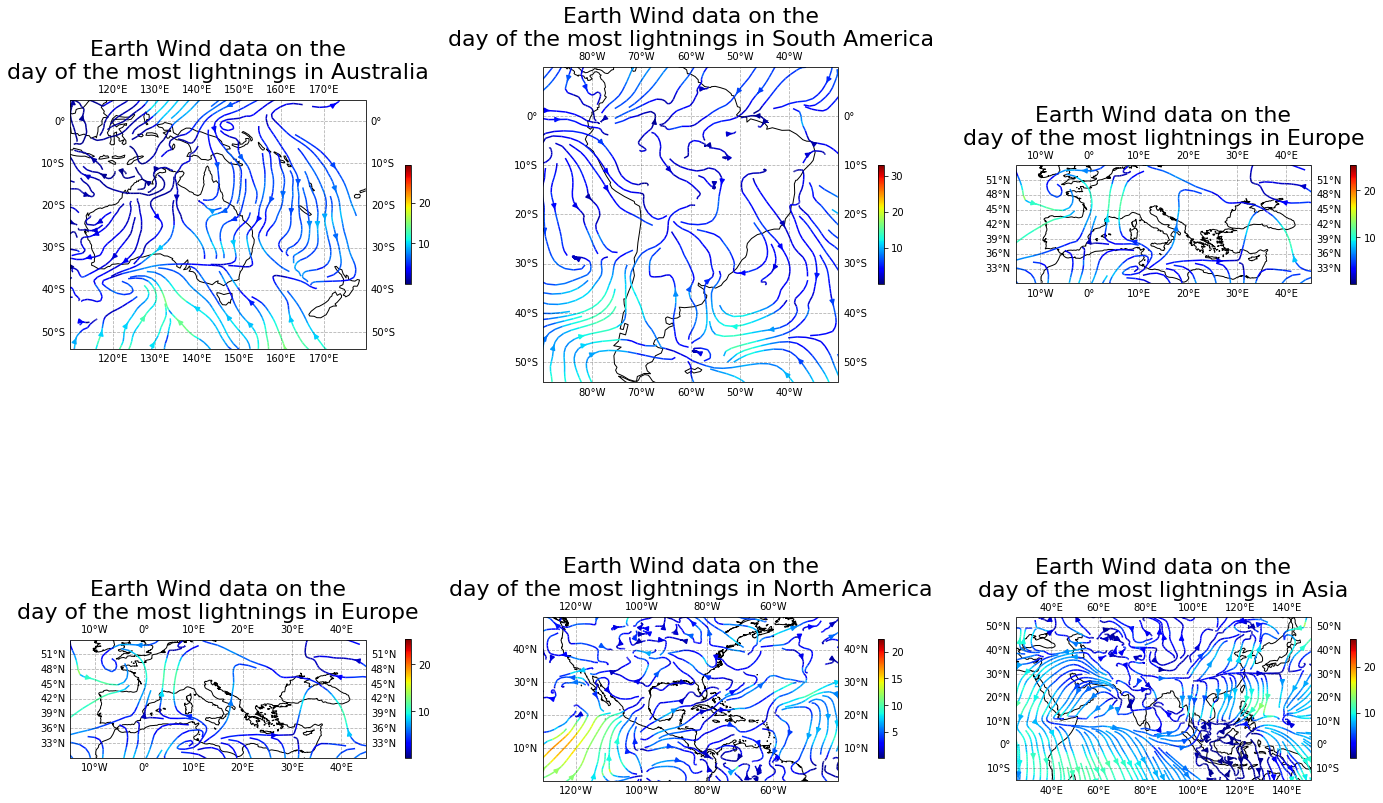

In [59]:
xlims_list = [(110,180),(-90,-30),(-15,45),(-130,-40),(25,150),(-25,55)]
ylims_list = [(-54,5),(-54,10),(30,54),(0,50),(-15,54),(-35,45)]
titles0 = ["Earth Wind data on the\nday of the most lightnings in Australia",
          "Earth Wind data on the\nday of the most lightnings in South America",
          "Earth Wind data on the\nday of the most lightnings in Europe",
          "Earth Wind data on the\nday of the most lightnings in North America",
          "Earth Wind data on the\nday of the most lightnings in Asia",
          "Earth Wind data on the\nday of the most lightnings in Africa"]


#init the subplots
fig, axes = plt.subplots(2,3, figsize=(24,16), subplot_kw={"projection" : ccrs.PlateCarree(central_longitude=0.0) })

for i in axes:
    for j in i:
        j.gridlines(crs=ccrs.PlateCarree(central_longitude=0.0),
                   draw_labels=True,
                   linewidth=0.8,
                   alpha=0.3,
                   color="black",
                   linestyle="--")
        j.coastlines(color="#000000")    #AAAAAA is actually a hex code
        
        j.set_xlabel("Longitude", fontsize=24)
        j.set_ylabel("Latitude", fontsize=24)

for idx,i in enumerate(axes):
    for idy,j in enumerate(i):
        u = np.array(net_cdfs[idx*2 + idy].variables['uwnd'])[1]
        v = np.array(net_cdfs[idx*2 + idy].variables['vwnd'])[1]
        
        im0 = j.streamplot(np.array(net_cdfs[idx*2 + idy].variables['longitude'])-180,
                          np.array(net_cdfs[idx*2 + idy].variables['latitude']),
                          v,
                          u,
                          density = 6.0,
                          color= (u**2 + v**2)**(1/2),
                          cmap='jet')
        fig.colorbar(im0.lines,ax=j,pad=0.1, shrink=0.3)
        
        j.set_title(titles0[idx*2 + idy], fontsize=22)
        j.set_xlim(xlims_list[idx*2 + idy])
        j.set_ylim(ylims_list[idx*2 + idy])

fig.tight_layout()
plt.savefig("../figs/wind_streamplot_20200.png", format="png", dpi=150)
plt.show()       

![ajsas](../figs/wind_streamplot_20200.png "put some txt here brah")

In [65]:
def plot_windspeed_from_netcdf(netcdf_data,topcoords,titles,figs,xlims,ylims,shrnk):
    V1_1 = np.array(netcdf_data.variables['uwnd'])[1]
    V1_2 = np.array(netcdf_data.variables['vwnd'])[1]
    
    stepx = netcdf_data['longitude'][0] - netcdf_data['longitude'][1]
    stepy = netcdf_data['latitude'][0] - netcdf_data['latitude'][1]
    edgex = np.zeros(len(netcdf_data.variables['longitude'][:])+1)
    edgey = np.zeros(len(netcdf_data.variables['latitude'][:])+1 )
    edgex[0] = netcdf_data.variables['longitude'][0] + stepx/2     #wrong
    edgey[0] = netcdf_data.variables['latitude'][0] + stepy/2

    edgex[1:] = netcdf_data.variables['longitude'][:] - stepx/2
    edgey[1:] = netcdf_data.variables['latitude'][:] - stepy/2
    
    XW, YW = np.meshgrid(edgex, edgey)
    XH, YH = np.meshgrid(x_edges, y_edges)
    
    marker_style = dict(color='tab:white', linestyle=' ', marker='o',
                    markersize=15, markerfacecoloralt='tab:red')

    fig, axes = plt.subplots(1,2, figsize=figs, subplot_kw={"projection" : ccrs.PlateCarree(central_longitude=0.0) })
    for i in axes:
        i.gridlines(crs=ccrs.PlateCarree(central_longitude=0.0),
                    draw_labels=True,
                    linewidth=0.8,
                    alpha=0.3,
                    color="black",
                    linestyle="--")
        i.coastlines(color="white")
        i.set_xlabel("Longitude [°]",fontsize=28)
        i.set_ylabel("Latitude [°]",fontsize=28)
        i.set_xlim(xlims)
        i.set_ylim(ylims)
        
        i.plot(topcoords[:,0], topcoords[:,1], " wo", fillstyle='none', markersize=6)

    axes[0].set_title(titles[0], fontsize=24)
    axes[1].set_title(titles[1], fontsize=24)

    #heatmap
    
    im1 = axes[0].pcolormesh(XW, YW, np.log((V1_1**2 + V1_2**2)**(1/2)+1) )  #wind
    im2 = axes[1].pcolormesh(XH, YH, np.log(HIST2D+1) )                      #lightnings
    
    fig.colorbar(im1,ax=axes[0],pad = 0.1, shrink=shrnk )
    fig.colorbar(im2,ax=axes[1],pad = 0.1, shrink=shrnk )

    #fig.tight_layout()


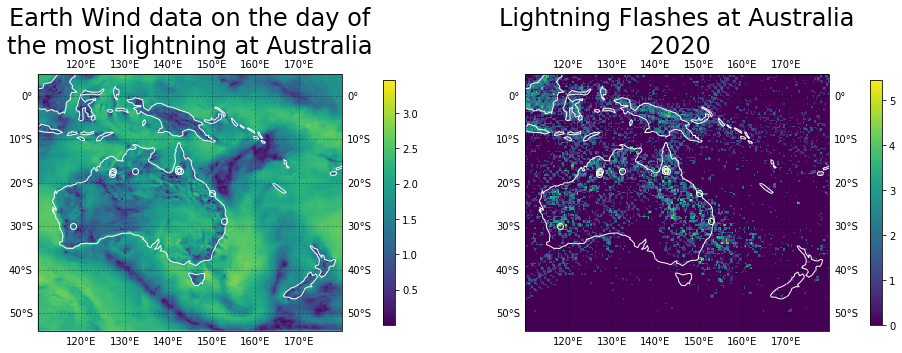

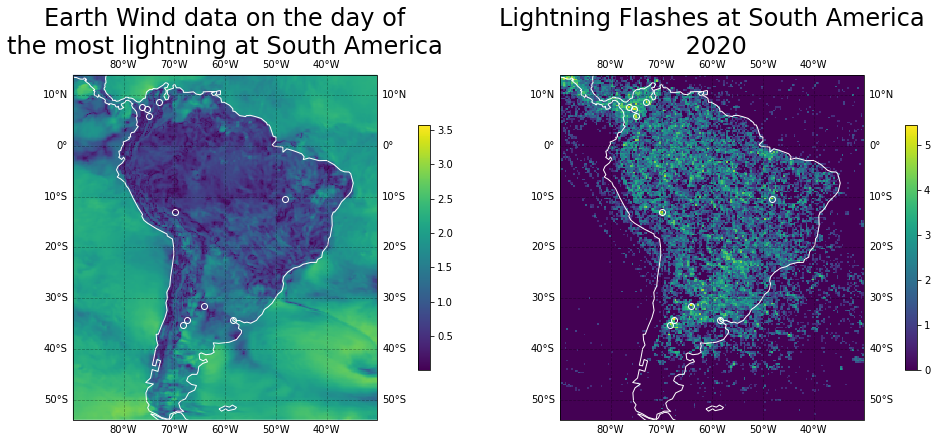

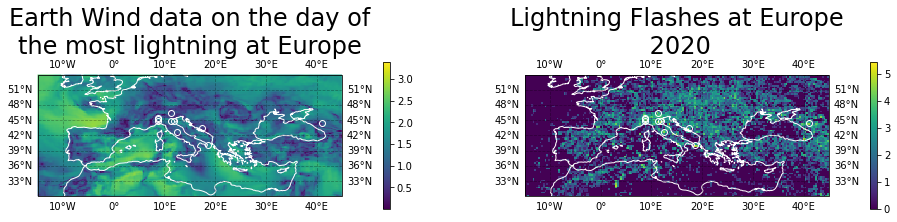

In [66]:
plot_windspeed_from_netcdf(au_wind,topN_coords_au,
                            ["Earth Wind data on the day of\nthe most lightning at Australia",
                             "Lightning Flashes at Australia\n 2020"],
                            (16,9),
                           (110,180),
                           (-54,5),
                          0.5)
plt.savefig("../figs/australia_wind_n_flash0.png", format="png", dpi=150, bbox_inches="tight")
plt.show()
plot_windspeed_from_netcdf(sa_wind,topN_coords_sa,
                            ["Earth Wind data on the day of\nthe most lightning at South America",
                             "Lightning Flashes at South America\n 2020"],
                            (16,9),
                           (-90,-30),
                           (-54,14),
                          0.5)
plt.savefig("../figs/samerica_wind_n_flash0.png", format="png", dpi=150, bbox_inches="tight")
plt.show()
plot_windspeed_from_netcdf(eu_wind,topN_coords_eu,
                            ["Earth Wind data on the day of\nthe most lightning at Europe",
                             "Lightning Flashes at Europe\n 2020"],
                            (16,9),
                           (-15,45),
                           (30,54),
                          0.3)
plt.savefig("../figs/europe_wind_n_flash0.png", format="png", dpi=150, bbox_inches="tight")
plt.show()

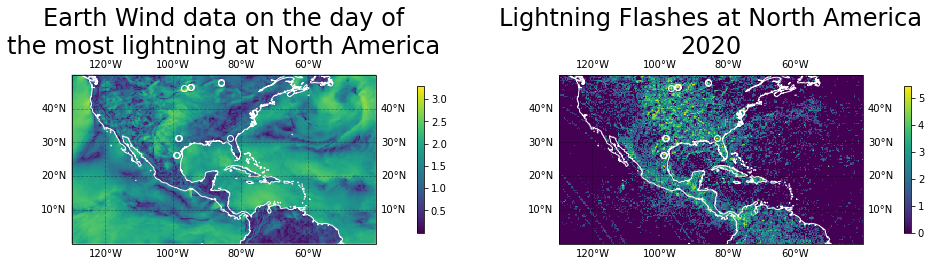

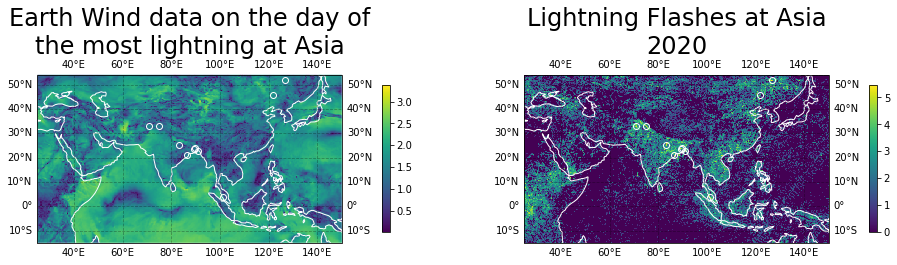

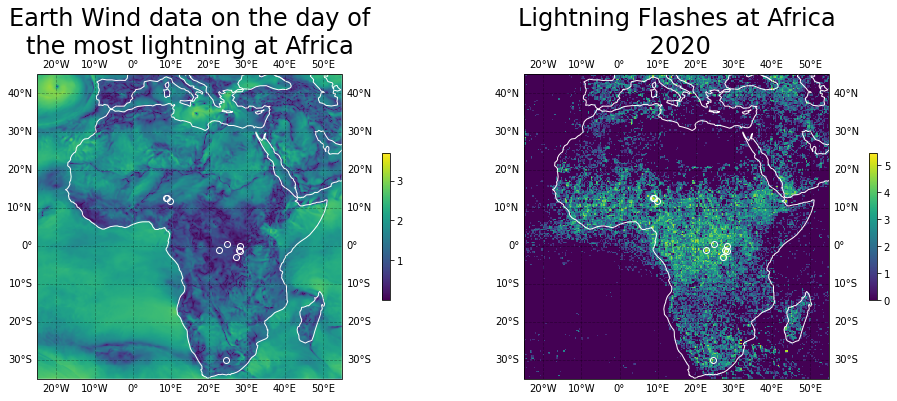

In [67]:
plot_windspeed_from_netcdf(na_wind,topN_coords_na,
                            ["Earth Wind data on the day of\nthe most lightning at North America",
                             "Lightning Flashes at North America\n2020"],
                            (16,9),
                           (-130,-40),
                           (0,50),
                          0.3)
plt.savefig("../figs/namerica_wind_n_flash0.png", format="png", dpi=150, bbox_inches="tight")
plt.show()
plot_windspeed_from_netcdf(as_wind,topN_coords_as,
                            ["Earth Wind data on the day of\nthe most lightning at Asia",
                             "Lightning Flashes at Asia\n2020"],
                            (16,9),
                           (25,150),
                           (-15,54),
                           0.3)
plt.savefig("../figs/asia_wind_n_flash0.png", format="png", dpi=150, bbox_inches="tight")
plt.show()
plot_windspeed_from_netcdf(af_wind,topN_coords_af,
                            ["Earth Wind data on the day of\nthe most lightning at Africa",
                             "Lightning Flashes at Africa\n 2020"],
                            (16,9),
                           (-25,55),
                           (-35,45),
                          0.3)
plt.savefig("../figs/africa_wind_n_flash0.png", format="png", dpi=150, bbox_inches="tight")
plt.show()

![ajsas](../figs/australia_wind_n_flash0.png "put some txt here brah")
![ajsas](../figs/africa_wind_n_flash0.png "put some txt here brah")

![ajsas](../figs/samerica_wind_n_flash0.png "put some txt here brah")
![ajsas](../figs/namerica_wind_n_flash0.png "put some txt here brah")

![ajsas](../figs/europe_wind_n_flash0.png "put some txt here brah")
![ajsas](../figs/asia_wind_n_flash0.png "put some txt here brah")

# SOURCES

[1] ${\bf \text{Where Are the Lightning Hotspots on Earth?}}$, Rachel I. Albrecht1, Steven J. Goodman2, Dennis E. Buechler3, Richard J. Blakeslee4, and Hugh J. Christian. 01 Nov. 2016.

[2] ${\bf \text{Remote Sensing Systems Cross-Calibrated Multi-Platform (CCMP) 6-hourly ocean vector wind analysis}}$ product on 0.25 deg grid, Version 2.0, Wentz, F.J., J. Scott, R. Hoffman, M. Leidner, R. Atlas, J. Ardizzone, 2015:  Remote Sensing Systems, Santa Rosa, CA.

Links:

LIS ISS data online: 
https://ghrc.nsstc.nasa.gov/lightning/data/data_lis_iss.html

WIND DATASET:
https://data.remss.com/ccmp/v02.1.NRT/

Github repository for the work:
https://github.com/AdamGTaylor/DataScience_Lab_2021

Great 3D map for Wind dataset:
https://www.nnvl.noaa.gov/weatherview/index.html